In [1]:
from Score_Matching import *
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from datetime import datetime
import torch

In [2]:
score_model = ScoreNet(image_dim=(1,28,28), 
                       use_condition=True,
                       num_classes=10,
                       device='cpu')

In [3]:
# Find last folder in checkpoints
import os
import datetime

def find_last_folder():
    folders = os.listdir(f"./Score_Matching/checkpoints/")
    last_folder = sorted(folders)[-1]
    return last_folder

folder_lastest_checkpoint = find_last_folder()

print("Load checkpoint: ", folder_lastest_checkpoint)
score_model.model.load_state_dict(torch.load(f"./Score_Matching/checkpoints/{folder_lastest_checkpoint}/model.pt", map_location=torch.device('cpu'), weights_only=True))


Load checkpoint:  20250114-100745


<All keys matched successfully>

In [32]:
n_epochs = 200 #@param {'type':'integer'}
## size of a mini-batch
batch_size = 128 #@param {'type':'integer'}
## learning rate
lr = 0.0005 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

# Filter only single digit
number = 0
dataset.data = dataset.data[dataset.targets == number]
dataset.targets = dataset.targets[dataset.targets == number]

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

KeyboardInterrupt: 

In [6]:
# score_model.load_state_dict(torch.load('score_model.pth', map_location='cuda'))
score_model.train(data_loader=data_loader,
                optimizer=Adam(score_model.model.parameters(), lr=lr),
                num_epochs=n_epochs,    
                device='cuda')


100%|██████████| 1000/1000 [00:28<00:00, 35.17it/s]


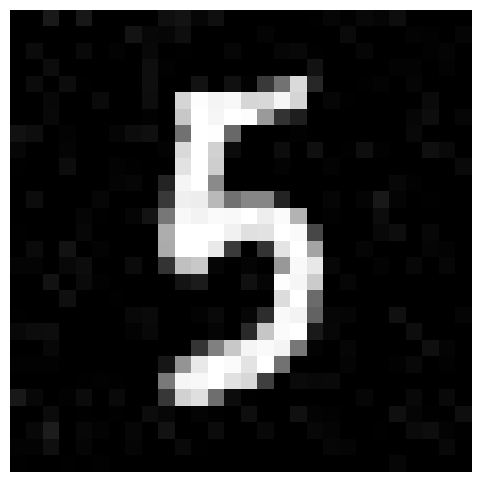

In [5]:
# Sampling 
n_samples = 1 #@param {'type':'integer'}


sampler = Predictor_Corrector_Sampler(score_model, signal_to_noise_ratio=0.16, device='cpu')

sampleres = sampler.sample(num_steps=100, 
               batch_size=n_samples, 
               sample_condition=torch.tensor([5]).to('cpu'))

image_state = sampleres.clamp(0.0, 1.0)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

sample_grid = make_grid(image_state, nrow=int(np.sqrt(n_samples)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [8]:
date = datetime.now().strftime("%Y%m%d-%H%M%S")
import os
os.makedirs(f'./checkpoints/{date}', exist_ok=True)
torch.save(score_model.model.state_dict(), f'./checkpoints/{date}/model.pt')